In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
from google.colab import drive

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)
dog_df = pd.read_csv(path + '/dogs.csv')

# need drive later for saved models
drive.mount('/content/drive')

100%|██████████| 215M/215M [00:12<00:00, 17.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2
Mounted at /content/drive


In [2]:
# libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
image_path = path + '/' + dog_df['filepaths'].iloc[0]

print(image_path)

/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train/Afghan/001.jpg


In [6]:
# get dataframes of dogs by train/test/validation

train_df = dog_df[dog_df.iloc[:, 2] == "train"].copy()
valid_df = dog_df[dog_df.iloc[:, 2] == "valid"].copy()
test_df = dog_df[dog_df.iloc[:, 2] == "test"].copy()
train_df.head()

# get folder paths of dogs by train/test/validation

train_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train'
valid_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/valid'
test_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/test'

Below is preprocessing + resnet50 model attempt

In [7]:
# considered grayscale but read online somewhere that color is helpful for breed identification
# preprocessing tasks - shear, zoom, flip.

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    shear_range=0.2,            # shear
    zoom_range=0.2,             # zoom
    horizontal_flip=True       # Flip images
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test/validation

# train, test, validation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(228, 228),    # Resize images
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(228, 228),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(228, 228),
    batch_size=32,
    class_mode='categorical'
)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


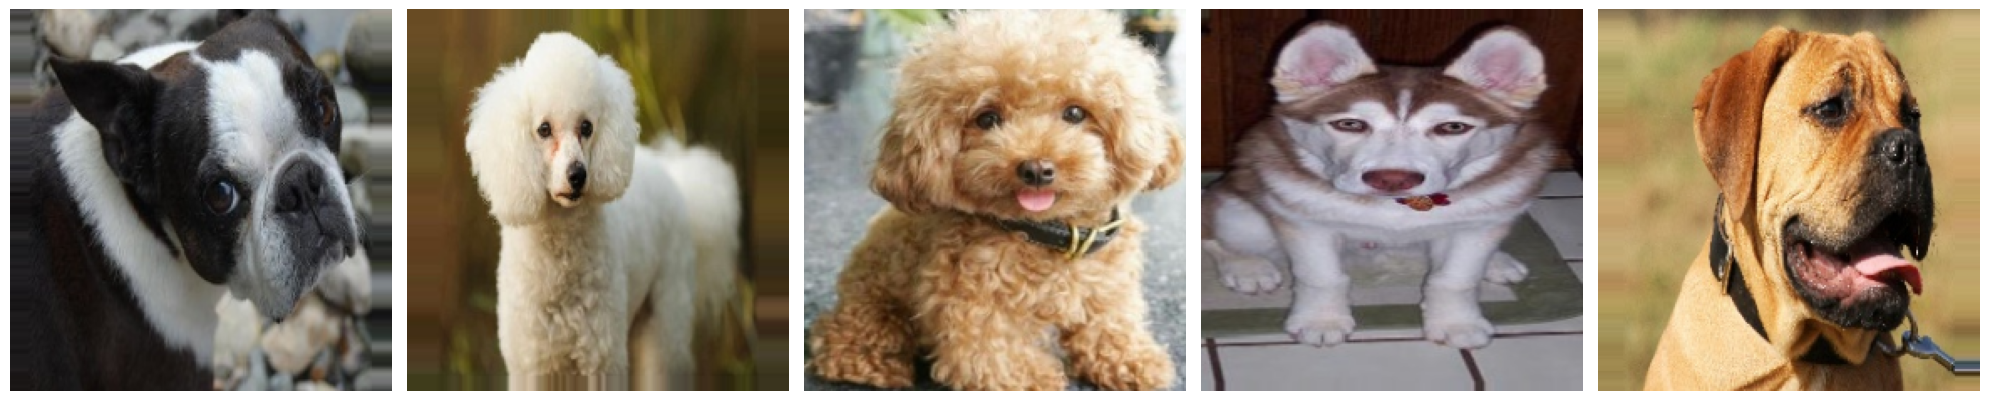

In [6]:
# test to ensure images look good

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


sample_training_images, _ = next(train_generator)
plot_images(sample_training_images[:5])

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [8]:
# Load model
base_model = ResNet50(weights='imagenet', include_top=False)

# Classifier
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(70, activation='softmax'))  # 70 to match our earlier shape

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(train_generator,epochs=50, validation_data=validation_generator)
model.save('/content/drive/My Drive/AA502_Computer_Vision/resnet50_base_dog_detection.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 179s 472ms/step - accuracy: 0.2262 - loss: 3.2120 - val_accuracy: 0.0143 - val_loss: 5.0390
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 86s 334ms/step - accuracy: 0.5925 - loss: 1.3948 - val_accuracy: 0.0186 - val_loss: 5.1564
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 86s 336ms/step - accuracy: 0.7065 - loss: 0.9691 - val_accuracy: 0.0729 - val_loss: 5.0778
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.7710 - loss: 0.7488 - val_accuracy: 0.5600 - val_loss: 1.8962
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.7894 - loss: 0.6602 - val_accuracy: 0.1686 - val_loss: 6.8106
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.8414 - loss: 0.5017 - val_accuracy: 0.5300 - val_loss: 2.0355
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.8706 - loss: 0.4291 - val_accuracy: 0.4971 - val_loss: 2.4807
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.8727 - loss: 0.3898 - va

In [9]:
# save model for later use (evaluation, etc)

Above attempt went really well!. Attempting resnet50 model again with adjustments for curiosity



In [10]:
# making adjustments to Learning Rate, Freezing Layers, optimizers
from tensorflow.keras.optimizers import SGD # different optimizer

# same as before
base_model_adjusted = ResNet50(weights='imagenet', include_top=False)
model_adjusted = Sequential()
model_adjusted.add(base_model_adjusted)
model_adjusted.add(GlobalAveragePooling2D())
model_adjusted.add(Dense(70, activation='softmax'))

# Freeze layers - https://stackoverflow.com/questions/46610732/how-to-freeze-some-layers-when-fine-tune-resnet50
# https://www.linkedin.com/advice/0/how-can-you-determine-which-layers-freeze-when-okd8f#:~:text=1.-,Why%20Freeze%20Layers%3F,a%20similar%20structure%20or%20content.
for layer in base_model_adjusted.layers:
    layer.trainable = False
model_adjusted.save_weights("all_nontrainable.weights.h5")

base_model_adjusted = ResNet50(weights='imagenet', include_top=False)
model_adjusted = Sequential()
model_adjusted.add(base_model_adjusted)
model_adjusted.add(GlobalAveragePooling2D())
model_adjusted.add(Dense(70, activation='softmax'))

for layer in base_model_adjusted.layers[:-26]:
    layer.trainable = False
model_adjusted.load_weights("all_nontrainable.weights.h5")

# Compile
model_adjusted.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model_adjusted.fit(train_generator,epochs=50, validation_data=validation_generator)
model_adjusted.save('/content/drive/My Drive/AA502_Computer_Vision/resnet50_with_adjustments_dog_detection.h5')

Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 104s 363ms/step - accuracy: 0.0233 - loss: 4.2802 - val_accuracy: 0.0257 - val_loss: 4.2380
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 330ms/step - accuracy: 0.0424 - loss: 4.1402 - val_accuracy: 0.0514 - val_loss: 4.1111
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 329ms/step - accuracy: 0.0636 - loss: 4.0454 - val_accuracy: 0.0557 - val_loss: 4.0067
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 331ms/step - accuracy: 0.0786 - loss: 3.9697 - val_accuracy: 0.0714 - val_loss: 3.9459
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 330ms/step - accuracy: 0.0874 - loss: 3.8998 - val_accuracy: 0.0843 - val_loss: 3.8755
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 328ms/step - accuracy: 0.1032 - loss: 3.8397 - val_accuracy: 0.1043 - val_loss: 3.8066
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 328ms/step - accuracy: 0.1069 - loss: 3.7725 - val_accuracy: 0.1200 - val_loss: 3.7153
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 329ms/step - accuracy: 0.1279 - loss: 

CNN architecture


In [11]:
!pip install tensorflow.keras.layers
!pip install tensorflow.keras.optimizers
!pip install keras.models
!pip install keras.layers
!pip install keras.utils
!pip install keras.preprocessing.image

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.layers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.layers
ERROR: Could not find a version that satisfies the requirement tensorflow.keras.optimizers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.optimizers
ERROR: Could not find a version that satisfies the requirement keras.layers (from versions: none)
ERROR: No matching distribution found for keras.layers
  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2632 sha256=cda3a8bc45e59e400ec5010d156cf62f852386a97ee46ce54222507f68b65199
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils
ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found f

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout , Input , BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale, create directory paths
datagen = ImageDataGenerator(rescale=1./255,)

train_dir = path + '/train/'
test_dir = path + '/test/'
val_dir = path + '/valid/'

In [12]:
train_dataset = datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(228,228),
    class_mode='categorical'
)

# Load testing data
test_dataset = datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(228,228),
    class_mode='categorical'
)
val_dataset = datagen.flow_from_directory(
    val_dir,
    batch_size=64,
    target_size=(228,228),
    class_mode='categorical'
)
num_classes = 70

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [15]:
input_shape = (228, 228, 3)

cnn_model = Sequential([
    Input(shape=input_shape),

    # Convolutional Blocks
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(70, activation='softmax')
])

In [16]:
history = cnn_model.fit(train_dataset, epochs=50, validation_data=val_dataset , batch_size=32 , verbose=1)
cnn_model.save('/content/drive/My Drive/AA502_Computer_Vision/dog_cnn_model.h5')


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - accuracy: 0.0283 - loss: 6.9475 - val_accuracy: 0.0171 - val_loss: 4.2459
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.0520 - loss: 4.2653 - val_accuracy: 0.0157 - val_loss: 4.6823
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.0640 - loss: 4.0680 - val_accuracy: 0.0186 - val_loss: 4.2351
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.0803 - loss: 3.9530 - val_accuracy: 0.0614 - val_loss: 4.2488
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.1073 - loss: 3.8122 - val_accuracy: 0.0486 - val_loss: 4.0067
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.1200 - loss: 3.6738 - val_accuracy: 0.0729 - val_loss: 4.0113
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.1394 - loss: 3.5576 - val_accuracy: 0.0729 - val_loss: 3.9373
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.1617 - loss: 3.

Now  that we've trained resnet50/CNN models, running some evaluation on them using test sets from earlier.

In [14]:
from tensorflow.keras.models import load_model

resnet50_base_model = load_model('/content/drive/My Drive/AA502_Computer_Vision/resnet50_base_dog_detection.h5')
resnet50_adjusted_model = load_model('/content/drive/My Drive/AA502_Computer_Vision/resnet50_with_adjustments_dog_detection.h5')
cnn_model = load_model('/content/drive/My Drive/AA502_Computer_Vision/dog_cnn_model.h5')

resnet50_base_model_predictions = resnet50_base_model.predict(test_generator)
resnet50_adjusted_model_predictions = resnet50_adjusted_model.predict(test_generator)
cnn_model_predictions = cnn_model.predict(test_dataset)


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

resnet50_predictions = np.argmax(resnet50_base_model_predictions, axis=1)
resnet50_adjusted_predictions = np.argmax(resnet50_adjusted_model_predictions, axis=1)
cnn_predictions = np.argmax(cnn_model_predictions, axis=1)

# same just repeating
y_true = test_generator.classes
y_true_cnn = test_dataset.classes


# Evaluate ResNet50
resnet50_acc = accuracy_score(y_true, resnet50_predictions)
resnet50_precision = precision_score(y_true, resnet50_predictions, average='macro')
resnet50_recall_score = recall_score(y_true, resnet50_predictions, average='macro')
resnet50_f1_score = f1_score(y_true, resnet50_predictions, average='macro')
resnet50_confusion_matrix = confusion_matrix(y_true, resnet50_predictions)

print("resnet50 base model accuracy: ", resnet50_acc)
print("resnet50 base model precision: ", resnet50_precision)
print("resnet50 base model recall: ", resnet50_recall_score)
print("resnet50 base model f1: ", resnet50_f1_score)
print("resnet50 base model confusion matrix: ", resnet50_confusion_matrix)

# non-base model
resnet50_adj_acc = accuracy_score(y_true, resnet50_adjusted_predictions)
resnet50_adj_precision = precision_score(y_true, resnet50_adjusted_predictions, average='macro')
resnet50_adj_recall_score = recall_score(y_true, resnet50_adjusted_predictions, average='macro')
resnet50_adj_f1_score = f1_score(y_true, resnet50_adjusted_predictions, average='macro')
resnet50_adj_confusion_matrix = confusion_matrix(y_true, resnet50_adjusted_predictions)

print("resnet50 adj model accuracy: ", resnet50_adj_acc)
print("resnet50 adj model precision: ", resnet50_adj_precision)
print("resnet50 adj model recall: ", resnet50_adj_recall_score)
print("resnet50 adj model f1: ", resnet50_adj_f1_score)
print("resnet50 adj model confusion matrix: ", resnet50_adj_confusion_matrix)

# # Evaluate CNN
cnn_acc = accuracy_score(y_true, cnn_predictions)
cnn_precision = precision_score(y_true, cnn_predictions, average='macro')
cnn_recall_score = recall_score(y_true, cnn_predictions, average='macro')
cnn_f1_score = f1_score(y_true, cnn_predictions, average='macro')
cnn_confusion_matrix = confusion_matrix(y_true, cnn_predictions)

print("cnn model accuracy: ", cnn_acc)
print("cnn model precision: ", cnn_precision)
print("cnn model recall: ", cnn_recall_score)
print("cnn model f1: ", cnn_f1_score)
print("cnn model confusion matrix: ", cnn_confusion_matrix)

resnet50 base model accuracy:  0.022857142857142857
resnet50 base model precision:  0.026905079047936188
resnet50 base model recall:  0.022857142857142857
resnet50 base model f1:  0.022597074985600648
resnet50 base model confusion matrix:  [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]
resnet50 adj model accuracy:  0.008571428571428572
resnet50 adj model precision:  0.020064251466690494
resnet50 adj model recall:  0.008571428571428572
resnet50 adj model f1:  0.008184271212125374
resnet50 adj model confusion matrix:  [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
cnn model accuracy:  0.011428571428571429
cnn model precision:  0.026706349206349206
cnn model recall:  0.011428571428571427
cnn model f1:  0.012991542709587823
cnn model confusion matrix:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation scores were quite poor. Trying on an image

In [22]:
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/My Drive/AA502_Computer_Vision/DSC01372_Original.jpg'
img = image.load_img(img_path, target_size=(228, 228))  # Resize to match our input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# test image against all models
resnet50_base_model_predictions = resnet50_base_model.predict(img_array)
resnet50_adjusted_model_predictions = resnet50_adjusted_model.predict(img_array)
cnn_model_predictions = cnn_model.predict(img_array)

resnet50_predictions_for_single_image = np.argmax(resnet50_base_model_predictions, axis=1)
resnet50_adjusted_predictions_for_single_image = np.argmax(resnet50_adjusted_model_predictions, axis=1)
cnn_predictions_for_single_image = np.argmax(cnn_model_predictions, axis=1)

# to get breed predicted
class_indices = test_generator.class_indices
index_to_class = {a: b for b, a in class_indices.items()}

print("ResNet50 Prediction:", index_to_class[resnet50_predictions_for_single_image[0]])
print("ResNet50 adjusted Prediction:", index_to_class[resnet50_adjusted_predictions_for_single_image[0]])
print("CNN Prediction:", index_to_class[cnn_predictions_for_single_image[0]])




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
ResNet50 Prediction: Great Perenees
ResNet50 Prediction: Groenendael
CNN Prediction: Chinese Crested


Dog in single image was supposed to be (Akita) so it doesn't bode well for resnet50 and cnn models did not come close.